In [1]:
import struct
from pynq import Overlay
from pynq import DefaultIP
from pynq.lib.video import *

import time
import PIL.Image
import asyncio

In [2]:
class Mandelbrot(DefaultIP):
    def __init__(self, description):
        super().__init__(description=description)       
        # Enable interrupts for ap_done
        self.write(0x04,1)
        self.write(0x08,1)
        # Setup default resolution
        self.resolution(1920, 1080)
        # Setup default config
        self.config(3.5, 2.0, -2.5, 1.0, 100)
        
    bindto = ['xilinx.com:hls:mandelbrot:1.0']
    
    def resolution(self, img_width, img_height):
        self.write(0x10,1920)
        self.write(0x18,1080)
    
    def config(self, plot_width, plot_height, x_min, y_max, iterations):
        self.write(0x20,struct.pack('d', plot_width))
        self.write(0x2c,struct.pack('d', plot_height))
        self.write(0x38,struct.pack('d', x_min))
        self.write(0x44,struct.pack('d', y_max))
        self.write(0x50,iterations)
    
    def set_plot_width(self, plot_width):
        self.write(0x20,struct.pack('d', plot_width))
    
    def set_plot_height(self, plot_height):
        self.write(0x2c,struct.pack('d', plot_height))
    
    def set_x_min(self, x_min):
        self.write(0x38,struct.pack('d', x_min))
    
    def set_y_max(self, y_max):
        self.write(0x44,struct.pack('d', y_max))
    
    def set_iterations(self, iterations):
        self.write(0x50,iterations)
    
    def render(self):
        # Start IP
        self.write(0x00,1)
        # Wait for interrupt
        loop = asyncio.get_event_loop()
        while(self.read(0x0c) & 0x1 == 0):
            loop.run_until_complete(asyncio.ensure_future(self.interrupt.wait()))
        # Clear interrupt
        self.write(0x0c, 0x1)
        self.interrupt.event.clear()
        # Display output
        activeframe = vdma.readchannel.activeframe
        frame = vdma.readchannel._frames[activeframe]
        return PIL.Image.fromarray(frame)
    
    def timed_render(self):
        start = time.time()
        render = self.render()
        end = time.time()
        print("Render took:", end - start, "s")
        return render
        
        

In [3]:
class AxiVDMA_Custom(pynq.lib.video.dma.AxiVDMA):
    def __init__(self, description):
        super().__init__(description=description, framecount=2)
        
    bindto = ['xilinx.com:ip:axi_vdma:6.3']

In [4]:
overlay = Overlay('/home/xilinx/pynq/overlays/personal/Mandelbrot/Mandelbrot.bit')
mandelbrot = overlay.mandelbrot
vdma = overlay.axi_vdma
vdma.readchannel.mode = common.VideoMode(1920, 1080, 32)
vdma.readchannel.start()

In [5]:
mandelbrot.config(0.35, 0.2, -1.3, 0.35, 1000)

Render took: 227.60425734519958 s


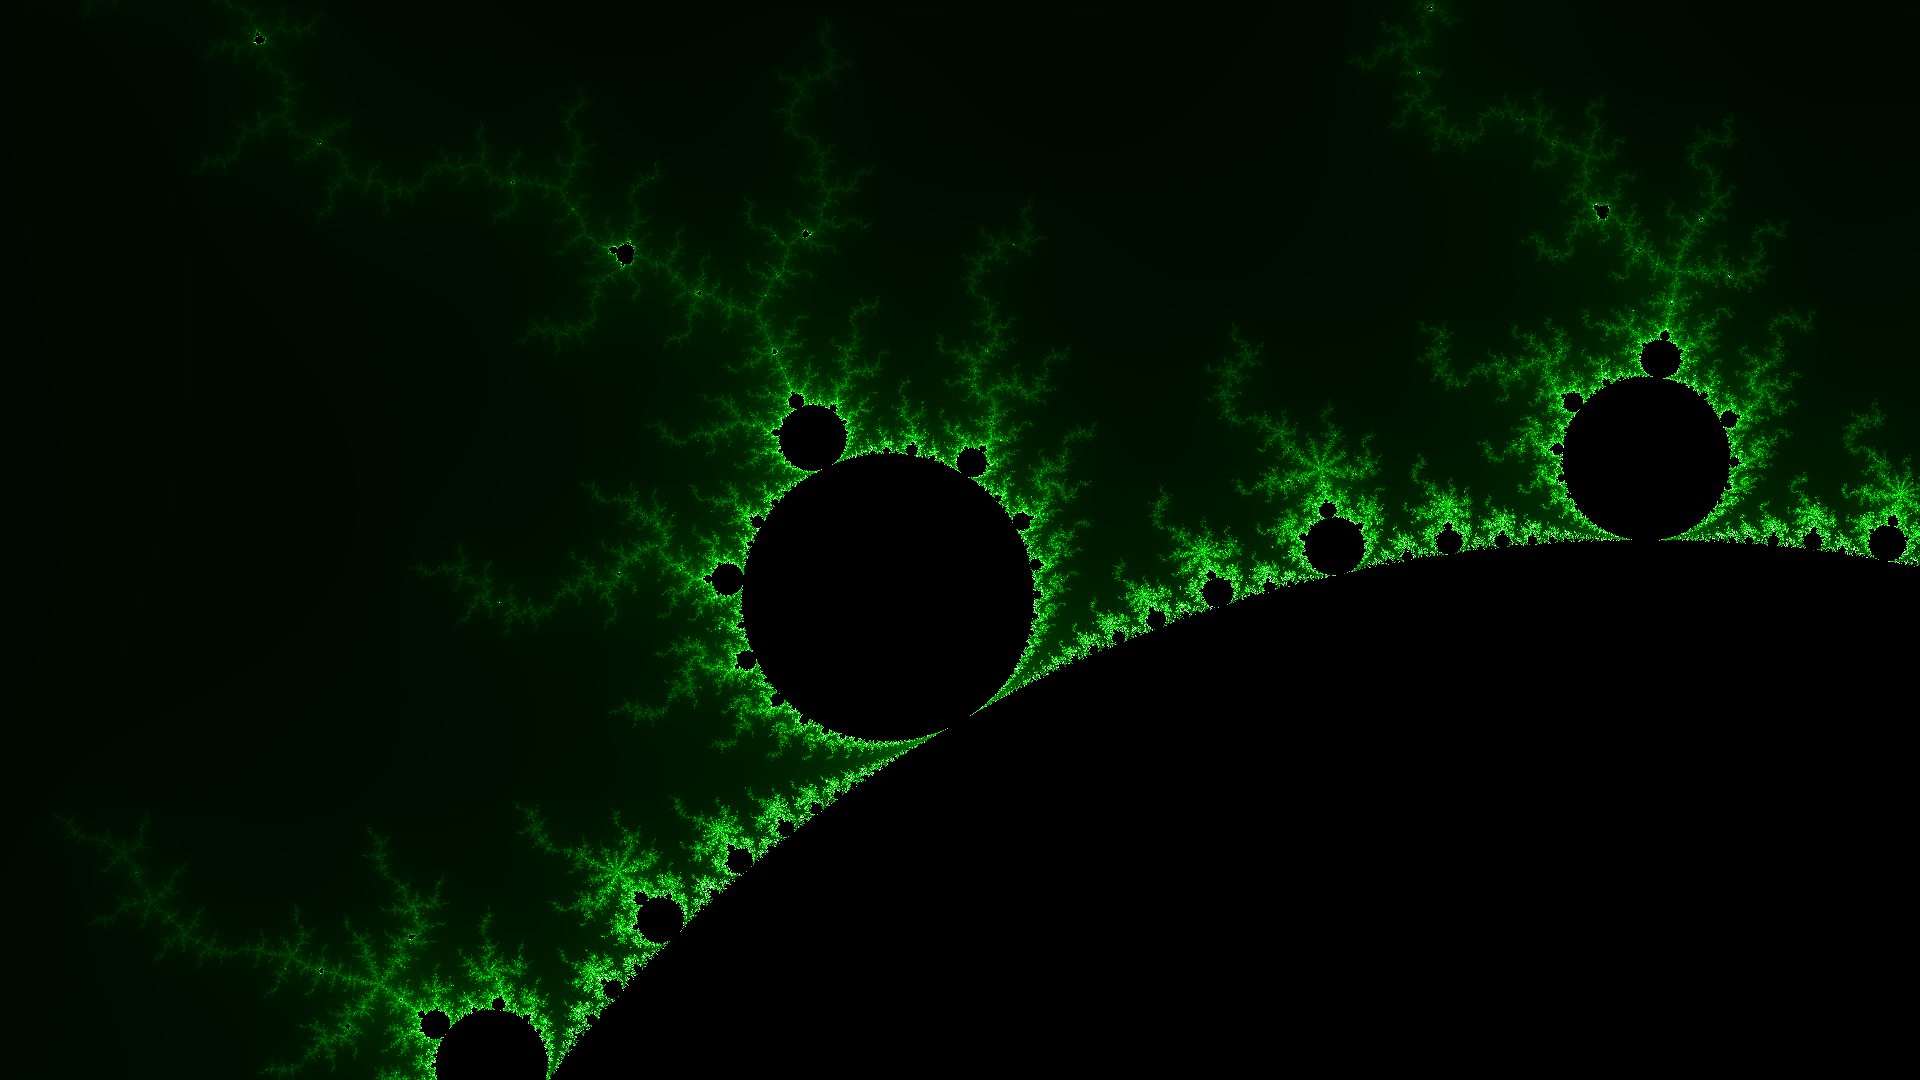

In [6]:
mandelbrot.timed_render()